In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import feature_extractor as fe
import data_cleaner as dc
# import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import pandas as pd
# import numpy as np
# sys.path.append('../..')
# import omama as O

In [3]:
# cache_path = "/home/ryan.zurrin001/binlink/sample_dataset.pkl"
cache_path = "/home/ryan.zurrin001/binlink/cs438_features_imgs.pkl"

In [4]:
# Load the DataFrame
df_features = pd.read_pickle(cache_path)

In [5]:
len(df_features)

163568

In [6]:
df_features.columns

Index(['path', 'label', 'StudyInstanceUID', 'ImageLaterality',
       'SOPInstanceUID', 'PatientAge', 'Manufacturer', 'ManufacturerModelName',
       'DistanceSourceToDetector', 'DistanceSourceToPatient', 'ExposureTime',
       'XRayTubeCurrent', 'Exposure', 'ExposureInuAs', 'KVP',
       'BodyPartThickness', 'CompressionForce', 'PositionerPrimaryAngle',
       'ViewPosition', 'DetectorTemperature', 'DetectorType',
       'FieldOfViewOrigin', 'Rows', 'Columns', 'PixelSpacing',
       'BreastImplantPresent', 'WindowCenter', 'WindowWidth', 'HalfValueLayer',
       'original_shape', 'shape', 'coords', 'resized_coords', 'score',
       'histogram', 'image'],
      dtype='object')

In [7]:
cleaner = dc.DataCleaner(df_features)

In [8]:
print("Initial length:", len(cleaner.df))

Initial length: 163568


In [9]:
cleaned_df = cleaner.clean_data()

Cleaning data...
drop unnecessary columns
handle missing values
process ages
label encode
map labels
handle missing values
add correctness column
expand and extend columns


Expanding Columns:   0%|          | 0/2 [00:00<?, ?it/s]

Extending Columns:   0%|          | 0/3 [00:00<?, ?it/s]

process and flatten columns
handle missing values


In [10]:
len(cleaned_df)

161299

In [11]:
cleaned_df.columns

Index(['label', 'ImageLaterality', 'PatientAge', 'Manufacturer',
       'ManufacturerModelName', 'DistanceSourceToDetector',
       'DistanceSourceToPatient', 'ExposureTime', 'XRayTubeCurrent',
       'Exposure', 'ExposureInuAs', 'KVP', 'BodyPartThickness',
       'CompressionForce', 'PositionerPrimaryAngle', 'ViewPosition',
       'DetectorTemperature', 'DetectorType', 'Rows', 'Columns', 'score',
       'target_label', 'coords1', 'coords2', 'coords3', 'coords4',
       'resized_coords1', 'resized_coords2', 'resized_coords3',
       'resized_coords4', 'FieldOfViewOrigin1', 'FieldOfViewOrigin2',
       'WindowCenter1', 'WindowCenter2', 'WindowCenter3', 'WindowCenter4',
       'WindowWidth1', 'WindowWidth2', 'WindowWidth3', 'WindowWidth4',
       'histogram_mean', 'histogram_median', 'histogram_std', 'histogram_min',
       'histogram_max', 'histogram_percentile_25', 'histogram_percentile_50',
       'histogram_percentile_75', 'flattened_image_mean',
       'flattened_image_median', 'fla

In [12]:
# Define your features and target variable
X = cleaned_df.drop('target_label', axis=1)  # all columns except the label
y = cleaned_df['target_label']  # the target variable

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [15]:
from sklearn.svm import SVC

svm_model = SVC(class_weight=class_weights_dict, random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(class_weight={0: 0.557095860604072, 1: 4.878601134215501}, random_state=42)

In [ ]:
from sklearn.svm import SVC

# Ensure you're using a linear kernel
linear_svm_model = SVC(kernel='linear', class_weight=class_weights_dict)
linear_svm_model.fit(X_train_scaled, y_train)

# Extract the coefficients
coefs = linear_svm_model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Displaying the feature importance
print(importance_df)


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = svm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28953
           1       0.83      0.99      0.90      3307

    accuracy                           0.98     32260
   macro avg       0.91      0.98      0.94     32260
weighted avg       0.98      0.98      0.98     32260

[[28263   690]
 [   25  3282]]


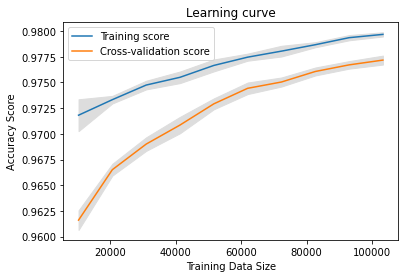

In [17]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=svm_model, X=X_train_scaled, y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1, scoring='accuracy'
)

# Calculate mean and standard deviation of train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')

plt.title('Learning curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()


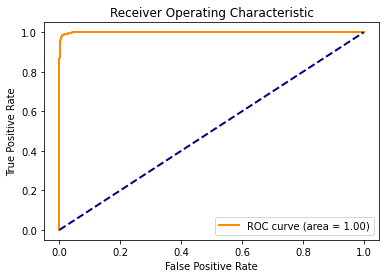

In [19]:
from sklearn.metrics import roc_curve, auc

y_scores = svm_model.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [20]:
import joblib
joblib.dump(svm_model, '/home/ryan.zurrin001/binlink/svm_model.pkl')

['/home/ryan.zurrin001/binlink/svm_model.pkl']